<a href="https://colab.research.google.com/github/aleks-haksly/KarpovCources_Hard_DA_advanced/blob/main/03%20-%20Advanced%20experiments%20design/04_statistical_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from statsmodels.stats.power import tt_ind_solve_power
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import ttest_ind
from scipy.stats import median_test

In [ ]:
data = pd.read_csv('bootstrap_homework.csv')

In [ ]:
# проверка пропусков (нет)
data.isna().sum()

passport_id    0
region         0
revenue        0
group          0
dtype: int64

### Задание 1. Размер эффекта (1/4) ###
Для начала попробуем определить размер эффекта. Для этого найдем несколько ключевых значений.

Найдите среднее значение revenue для группы 0.

Введите ответ в поле ниже с точностью до одного знака в десятичной части.

In [ ]:
print("среднее значение revenue для группы 0: {:.1f}".format(data.query('group == 0').revenue.mean()))

среднее значение revenue для группы 0: 1534.6


## Задание 1. Размер эффекта (2/4) ##
Найдите среднее значение revenue для группы 1.

Введите ответ в поле ниже с точностью до одного знака в десятичной части.

In [ ]:
print("среднее значение revenue для группы 0: {:.1f}".format(data.query('group == 1').revenue.mean()))

среднее значение revenue для группы 0: 1587.8


## Задание 1. Размер эффекта (3/4) ##
Рассчитайте абсолютный наблюдаемый эффект между двумя группами.

Введите ответ в поле ниже с точностью до одного знака в десятичной части.

In [ ]:
print("абсолютный наблюдаемый эффект между двумя группами: {:.1f}".format(data.groupby("group").revenue.mean().diff()[1]))

абсолютный наблюдаемый эффект между двумя группами: 53.2


## Задание 1. Размер эффекта (4/4) ##
Чему равен стандартизированный effect size Cohen D, найденный между группами, если std брать только по группе 0?

Введите ответ в поле ниже с точностью до трех знаков после запятой.

In [ ]:
cohen_d = data.groupby("group").revenue.mean().diff()[1] / data.query('group == 0').revenue.std()

In [ ]:
print("стандартизированный effect size Cohen D, найденный между группами, если std брать только по группе 0: {:.3f}".format(cohen_d))

стандартизированный effect size Cohen D, найденный между группами, если std брать только по группе 0: 0.007


## Задание 2. Размер выборки (1/4) ##
Определим, какая выборка нам была бы нужна для детекции 5% относительного эффекта в средних между группами.

Рассчитайте размер выборки, необходимый для детекции 5% относительных процентов в двустороннем t-test с alpha = 0.05, power = 0.8. За основу для расчета нужных параметров (mean, lift, std) используйте данные по группе 0.

In [ ]:
from statsmodels.stats.power import tt_ind_solve_power

In [ ]:
lift = 0.05
alpha = 0.05
power = 0.8
effect_size = data.query('group == 0').revenue.mean() * lift / data.query('group == 0').revenue.std()

In [ ]:
sample_size = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = "two-sided")
print('Sample size = ', math.ceil(sample_size))

Sample size =  162949


## Задание 2. Размер выборки (2/4) ##
А какая выборка нам была бы нужна, если бы мы использовали критерий Манна-Уитни?

Попробуем рассчитать с помощью симуляции размер выборки, для того чтобы задетектить те же 5%, но с помощью критерия Манна-Уитни.

Перед стартом симуляции укажите:

* np.random.seed(1)

Массив для перебора размера выборок начните с 500 до 5000 с шагом 100:



In [ ]:
data_mw = data.query('group == 0').revenue

In [ ]:
def u_test_power_calc(data, effect_size, sample_size, alpha=0.05, iters=1000, sample_replace=False):
  # func calculates Mann–Whitney U test power based on simulation

  # data: pandas DataFrame to sample from
  # effect_size: relative uplift in %
  # sample_size: number of records in sample needed
  # alpha: p-value critical level
  # sample_replace: sample type
  # iters: number of simulations


  ab_pvals = list()
  aa_pvals = list()
  for i in range(iters):
      #a_sample = data.sample(sample_size, replace=False)
      a_sample = np.random.choice(data, sample_size)
      a2_sample = np.random.choice(data, sample_size)
      #b_sample = data.sample(sample_size, replace=False) * (1 + effect_size)
      b_sample = np.random.choice(data, sample_size) * (1 + effect_size)
      ab_pvals.append(mannwhitneyu(a_sample, b_sample)[1])
      aa_pvals.append(mannwhitneyu(a_sample, a2_sample)[1])

  power = np.array(np.array(ab_pvals) < alpha).mean()
  # calculates 95% confidence interval for alpha
  alpha_CI_95 = proportion_confint(np.array(np.array(aa_pvals) < alpha).mean(), iters, alpha)
  if alpha_CI_95[1] >= alpha:
    print(f"Warning: 95% CI for alpha exceeds desired level {alpha}: {alpha_CI_95}")
  power_CI_95 = proportion_confint(np.array(np.array(ab_pvals) < alpha).sum(), iters, alpha)
  return list(power_CI_95)

In [ ]:
# range for power testing
test_range = range(1000, 4000, 100)

def power_plot(data, effect_size, test_range, seed, **kwargs):
  # plots power vs sample size and returns lower limit of 95% confidence interval of sample size for 80% power level
  np.random.seed(seed)
  power = list()
  for i in tqdm(test_range):
    power.extend(u_test_power_calc(data, effect_size, i, **kwargs))
  graph = sns.lineplot(x=sum([[i]*2 for i in test_range], []) , y=power)
  graph.set(xlabel='Sample size', ylabel='Power', title='Mann–Whitney U test: power vs sample size')
  xmin, xmax = graph.get_xlim()
  ymin, ymax = graph.get_ylim()
  graph.hlines(0.8, xmin, xmax, linestyles='dashed', colors='red')
  graph.vlines(test_range[np.argmax(np.array(power[::2]) >= 0.8)], ymin, ymax, linestyles='dashed', colors='red')

  return test_range[np.argmax(np.array(power[::2]) >= 0.8)]

In [ ]:
power

[]

  0%|          | 0/30 [00:00<?, ?it/s]

Sample size for 80% power level=2900


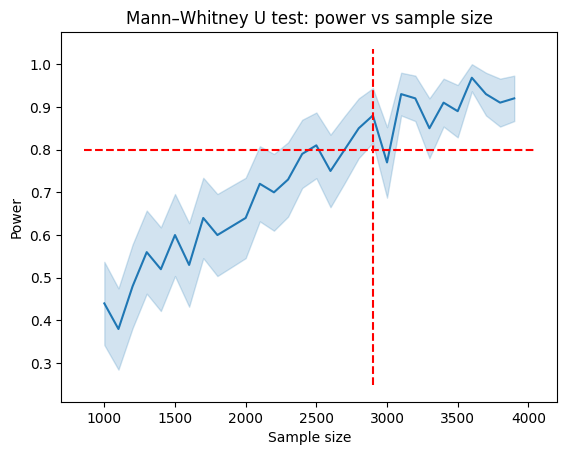

In [ ]:
p = power_plot(data_mw, 0.05, test_range, seed=1, iters=100)

In [ ]:
print(f"Sample size for 80% power level={p}")

Sample size for 80% power level=2900


## Задание 2. Размер выборки (3/4) ##
Хорошо, мы поняли какая выборка нужна была бы для детекции 5%, но наблюдаемый эффект у нас меньше относительного MDE. Интересно понять, какая выборка нам была бы нужна, чтобы задетектить MDE такого размера.

Рассчитайте размер выборки, необходимый для детекции наблюдаемого эффекта, найденного в задании 1, через двусторонний t-test. С альфа = 0.05 и мощностью 0.8. Выборка 50/50. Для определения cohen_D эффекта используйте std только по контрольной группе.

In [ ]:
cohen_d = data.groupby("group").revenue.mean().diff()[1] / data.query('group == 0').revenue.std()

In [ ]:
sample_size = tt_ind_solve_power(effect_size = cohen_d,
                       alpha = 0.05,
                       power = 0.8,
                       ratio = 1,
                       alternative = "two-sided",
                       nobs1 = None)


print('Required sample size to detect desired relative uplift: %s' % math.ceil(sample_size))

Required sample size to detect desired relative uplift: 338943


## Задание 2. Размер выборки (4/4) ##
Мы поняли, что наблюдаемый эффект меньше желаемого MDE, при этом и выборка у нас меньше нужного размера. Давайте посмотрим, какой MDE мы можем себе позволить на имеющейся выборке при проверке разницы средних через двусторонний t-test. Параметры дизайна теста те же самые.

Рассчитайте, какой абсолютный MDE вы можете себе позволить с датасетом имеющегося размера и std равным std в группе 0.

In [ ]:
MDE_abs = tt_ind_solve_power(effect_size=None, alpha = 0.05,
                       power = 0.8,
                       ratio = 1,
                       alternative = "two-sided",
                       nobs1 = len(data) / 2) * data.query('group == 0').revenue.std()

print('Абсолютный MDE, который вы можете позволить с датасетом имеющегося размера = ', round(MDE_abs, 1))

Абсолютный MDE, который вы можете позволить с датасетом имеющегося размера =  244.4


## Задание 3. Проверка стат.критерия (1/3) ##
Мы видим ряд проблем с размером теста, наблюдаемым эффектом и MDE. Но это не остановит нас в использовании стат критерия для проверки. Но перед использованием критерия желательно его проверить на исторических данных.

Проверьте, выдерживает ли нужный уровень ошибок (альфа и бета) Манна-Уитни или t-test. Оба теста двусторонние. Для симуляции используйте данные по группе 0. Используйте размер выборки, рассчитанный в задании 2 Размер выборки (1/4). Это размер выборки, нужный для детекции заданного менеджерами MDE. Кол-во симуляций = 1000. При старте симуляции указывайте np.random.seed(1), чтобы результаты были воспроизводимы.

Укажите мощность полученную при симуляции Манна Уитни

Введите ответ в поле ниже с точностью до одного знака в десятичной части.

In [ ]:
sample_size = 162949
alpha = 0.05
beta = 0.2
power = 1 - beta
historical_data = data.query('group == 0').revenue
iters = 1000
rel_lift = 0.05

In [ ]:
def power_calc(data, effect_size, sample_size, alpha=0.05, iters=1000, type='tt', sample_replace=True):
  # func calculates Mann–Whitney U test power based on simulation

  # data: pandas DataFrame to sample from
  # effect_size: relative uplift in %
  # sample_size: number of records in sample needed
  # alpha: p-value critical level
  # sample_replace: sample type
  # iters: number of simulations


  ab_pvals = list()
  aa_pvals = list()
  np.random.seed(1)
  for i in tqdm(range(iters)):
      a_sample = np.random.choice(hist_data, size = sample_size)
      a2_sample = np.random.choice(data, sample_size)
      b_sample = np.random.choice(hist_data, size = sample_size)*(1+rel_lift)

      if type == 'tt':
        ab_pvals.append(ttest_ind(a_sample, b_sample).pvalue)
        aa_pvals.append(ttest_ind(a_sample, a2_sample).pvalue)
      elif type == 'mw':
        ab_pvals.append(mannwhitneyu(a_sample, b_sample)[1])
        aa_pvals.append(mannwhitneyu(a_sample, a2_sample)[1])

  power = np.array(np.array(ab_pvals) < alpha).mean()
  aa_power = np.array(np.array(aa_pvals) < alpha).mean()
  print(f"Мощность теста: {power}, вероятность ошибки 1 рода: {aa_power}")


In [ ]:
power_calc(historical_data, relative_effect_size, sample_size, alpha=alpha, iters=iters, type='mw')

  0%|          | 0/1000 [00:00<?, ?it/s]

Мощность теста: 1.0, вероятиность ошибки 1 рода: 0.042


## Задание 3. Проверка стат.критерия (2/3) ##
Укажите мощность, полученную при симуляции t-test.

In [ ]:
power_calc(historical_data, relative_effect_size, sample_size, alpha=alpha, iters=iters, type='tt')

  0%|          | 0/1000 [00:00<?, ?it/s]

Мощность теста: 0.786, вероятиность ошибки 1 рода: 0.047


## Задание 3. Проверка стат.критерия (3/3) ##
**Что для нас значит разница в мощности критерия?**

Манна-Уитни проверяет не разницу средних. Средние, как мы видели ранее, не сильно отличаются в обеих группах.

А t-test честно позволяет проверить именно гипотезу о равенстве средних. Правда для этого ему нужны очень большие выборки. Но мы можем быть уверены в том, что проверим правильные параметры.

Сам факт более низкой мощности еще не повод откидывать критерий. Например, можно применить CUPED и другие методы снижения дисперсии и повысить мощность. При этом у t-test есть явные преимущество в интерпретируемости результата.

Более высокая мощность при проверке может также говорить о проблеме с критерием. Возможно критерий не заточен под проверку чего-то другого. Желательно проверять.

Ответ:

* Более высокая мощность у Манна-Уитни возможно вызвана характером распределения данных. Нам необходимо аккуратно применять его для проверки гипотез о центральных тенденциях распределения
* T-test имеет более низкую мощность, из-за высокой дисперсии в распределении. Но он честнее позволит найти ответ о разнице средних в рамках заданного MDE и дизайне эксперимента.

Неверно:
* Нужно однозначно использовать Манна-Уитни. Он позволит нам быстрее проверить гипотезу о разнице средних, т.к. у него мощность выше

В статистике нет ничего однозначного) Более высокая можность при проверке может также говорить о проблеме с критерием. Возможно критерий не заточен под проерку чего-то другого. Желательно проверять
* T-test не подходит для нашего эксперимента, т.к. у него мощность ниже

Сам факт более низкой мощности еще не повод откидывать критерий. например можно применить CUPED и другие методы снижения дисперсии и повысить мощность. При этом у t-test есть явные преимущество в интерпретируемости результата.

## Задание 4. Проверка гипотезы (1/5) ##
Ну и наконец мы добрались до применения стат критериев на наших данных. Проверяя нужный размер выборки и MDE, который мы можем себе позволить, мы уже интуитивно поняли, что в тесте вряд  ли задетектим желаемый MDE. Но все равно прогоним через стат.критерии.

Проверьте гипотезу о равенстве средних с помощью двустороннего t-test. Укажите полученное значение p-value.

In [ ]:
round(ttest_ind(data.query('group == 0').revenue, data.query('group == 1').revenue, alternative='two-sided').pvalue, 2)

0.54

## Задание 4. Проверка гипотезы (2/5) ##
Проверьте гипотезу о различиях в распределении revenue с помощью критерия Манна-Уитни. Укажите значение U-статистики, полученной в этом тесте.

In [ ]:
mannwhitneyu(data.query('group == 0').revenue, data.query('group == 1').revenue)

MannwhitneyuResult(statistic=137332553.5, pvalue=4.0824604776415004e-24)

## Задание 4. Проверка гипотезы (3/5) ##
Проверьте гипотезу о равенстве медиан в распределении с помощью Mood's median test. Укажите значение статистики, полученной в этом тесте.

In [ ]:
median_test(data.query('group == 0').revenue, data.query('group == 1').revenue)

MedianTestResult(statistic=108.81948173613007, pvalue=1.7775971068587562e-25, median=480.0, table=array([[8353, 7480],
       [7641, 8641]]))